# ATIS Dataset Exploration

In [17]:
import json
import pandas as pd
import numpy as np
with open('raw_datasets/ATIS/train.json', 'r') as f:
    data = json.load(f)

In [20]:
data['rasa_nlu_data']['common_examples']

[{'text': 'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning',
  'intent': 'flight',
  'entities': [{'start': 19,
    'end': 25,
    'value': 'boston',
    'entity': 'fromloc.city_name'},
   {'start': 29, 'end': 35, 'value': '838 am', 'entity': 'depart_time.time'},
   {'start': 50, 'end': 56, 'value': 'denver', 'entity': 'toloc.city_name'},
   {'start': 60, 'end': 64, 'value': '1110', 'entity': 'arrive_time.time'},
   {'start': 72,
    'end': 79,
    'value': 'morning',
    'entity': 'arrive_time.period_of_day'}]},
 {'text': 'what flights are available from pittsburgh to baltimore on thursday morning',
  'intent': 'flight',
  'entities': [{'start': 32,
    'end': 42,
    'value': 'pittsburgh',
    'entity': 'fromloc.city_name'},
   {'start': 46, 'end': 55, 'value': 'baltimore', 'entity': 'toloc.city_name'},
   {'start': 59,
    'end': 67,
    'value': 'thursday',
    'entity': 'depart_date.day_name'},
   {'start': 68,
    'end': 75,
    'value': 'morning',

In [23]:
df = pd.DataFrame()
df["text"] = np.array([sample['text'] for sample in data['rasa_nlu_data']['common_examples']])
df["intent"] = np.array([sample['intent'] for sample in data['rasa_nlu_data']['common_examples']])
df["entities"] = np.array([sample['entities'] for sample in data['rasa_nlu_data']['common_examples']])

In [33]:
def sep(x):
    if x.find('+') != -1:
        return x.split('+')
    else:
        return x
df['intent'] = df['intent'].map(lambda x: sep(x))

In [37]:
multi_intents = [i for i in df['intent'] if type(i) == list]

## 1. Document Pooling embedding

In [39]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, Sentence

# initialize the word embeddings
glove_embedding = WordEmbeddings('glove')
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')

# initialize the document embeddings, mode = mean
document_embeddings = DocumentPoolEmbeddings([glove_embedding,
                                              flair_embedding_backward,
                                              flair_embedding_forward])

2019-09-30 22:28:30,102 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmpjhq_2uj0


100%|██████████| 160000128/160000128 [00:11<00:00, 13743566.33B/s]

2019-09-30 22:28:42,453 copying /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmpjhq_2uj0 to cache at /Users/waynewu/.flair/embeddings/glove.gensim.vectors.npy


2019-09-30 22:28:43,039 removing temp file /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmpjhq_2uj0
2019-09-30 22:28:43,578 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmptwcn30ye


100%|██████████| 21494764/21494764 [00:06<00:00, 3345051.90B/s]

2019-09-30 22:28:50,648 copying /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmptwcn30ye to cache at /Users/waynewu/.flair/embeddings/glove.gensim


2019-09-30 22:28:50,696 removing temp file /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmptwcn30ye
2019-09-30 22:28:52,723 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-forward--h2048-l1-d0.05-lr30-0.25-20/news-forward-0.4.1.pt not found in cache, downloading to /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmpm5eka57p


100%|██████████| 73034624/73034624 [00:06<00:00, 10579432.53B/s]

2019-09-30 22:29:00,215 copying /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmpm5eka57p to cache at /Users/waynewu/.flair/embeddings/news-forward-0.4.1.pt


2019-09-30 22:29:00,369 removing temp file /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmpm5eka57p
2019-09-30 22:29:01,324 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/big-news-backward--h2048-l1-d0.05-lr30-0.25-20/news-backward-0.4.1.pt not found in cache, downloading to /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmp8ez4a8b3


100%|██████████| 73034575/73034575 [00:06<00:00, 10789968.03B/s]

2019-09-30 22:29:08,856 copying /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmp8ez4a8b3 to cache at /Users/waynewu/.flair/embeddings/news-backward-0.4.1.pt


2019-09-30 22:29:09,103 removing temp file /var/folders/79/8vg87rnd3rj6bg7rtfq66cvr0000gn/T/tmp8ez4a8b3


## 2. Semantic Parsing Dataset

In [29]:
import json
import pandas as pd
import numpy as np
import os
import re

In [20]:
data = pd.read_csv('./raw_datasets/top-dataset-semantic-parsing/train.tsv', sep='\t', names = ["question", "question2", "info"])

In [60]:
data["info"].values

'[IN:GET_ESTIMATED_DURATION How long will it take to [SL:METHOD_TRAVEL drive ] from [SL:SOURCE Chicago ] to [SL:DESTINATION Mississippi ] ]'

In [82]:
re.findall(r'\[IN:(\w+)', data["info"].values[0])

['GET_ESTIMATED_DURATION']

In [89]:
data["intent"] = data["info"].apply(lambda x: "_".join(sorted(re.findall(r'\[IN:(\w+)', x))))

In [90]:
data

,question,question2,info,intent
0,How long will it take to drive from Chicago to...,How long will it take to drive from Chicago to...,[IN:GET_ESTIMATED_DURATION How long will it ta...,GET_ESTIMATED_DURATION
1,Will it take shorter to get to the White House...,Will it take shorter to get to the White House...,[IN:UNSUPPORTED_NAVIGATION Will it take shorte...,UNSUPPORTED_NAVIGATION
2,will I make it to the beach by noon if I leave...,will I make it to the beach by noon if I leave...,[IN:GET_ESTIMATED_ARRIVAL will I make it to [S...,GET_ESTIMATED_ARRIVAL_GET_LOCATION
3,When should I leave my house to get to the Ham...,When should I leave my house to get to the Ham...,[IN:GET_ESTIMATED_DEPARTURE When should I leav...,GET_ESTIMATED_DEPARTURE_GET_LOCATION_GET_LOCAT...
4,I need to know if there's a lot of traffic on ...,I need to know if there 's a lot of traffic on...,[IN:GET_INFO_TRAFFIC I need to know if there '...,GET_INFO_TRAFFIC_GET_LOCATION_HOME
5,What is the shortest way home,What is the shortest way home,[IN:GET_DIRECTIONS What is the shortest way [S...,GET_DIRECTIONS_GET_LOCATION_HOME
6,how long will it take me to drive to fort collins,how long will it take me to drive to fort collins,[IN:GET_ESTIMATED_DURATION how long will it ta...,GET_ESTIMATED_DURATION
7,how long would it take to ride a bus to jeddah...,how long would it take to ride a bus to jeddah...,[IN:GET_ESTIMATED_DURATION how long would it t...,GET_ESTIMATED_DURATION
8,Can you tell me what is happening at Liberty S...,Can you tell me what is happening at Liberty S...,[IN:GET_EVENT Can you tell me what is happenin...,GET_EVENT_GET_LOCATION
9,traffic to Midway Airport,traffic to Midway Airport,[IN:GET_INFO_TRAFFIC traffic to [SL:DESTINATIO...,GET_INFO_TRAFFIC_GET_LOCATION


# 3. MULTIWOZ2.1

In [1]:
import json
import pandas as pd
import numpy as np
with open('raw_datasets/MULTIWOZ2.1/data.json', 'r') as f:
    data = json.load(f)

In [2]:
data.keys()

dict_keys(['SNG01856.json', 'SNG0129.json', 'PMUL1635.json', 'MUL2168.json', 'SNG0073.json', 'SNG01445.json', 'MUL2105.json', 'PMUL1690.json', 'MUL2395.json', 'SNG0190.json', 'PMUL1170.json', 'SNG01741.json', 'PMUL4899.json', 'MUL2261.json', 'SSNG0348.json', 'MUL0784.json', 'MUL0886.json', 'PMUL2512.json', 'SNG0548.json', 'MUL1474.json', 'PMUL4372.json', 'PMUL4047.json', 'PMUL1181.json', 'PMUL0287.json', 'PMUL3470.json', 'PMUL0151.json', 'MUL0586.json', 'PMUL3552.json', 'PMUL1539.json', 'MUL1790.json', 'PMUL3021.json', 'SNG0699.json', 'SNG0228.json', 'PMUL3296.json', 'MUL1434.json', 'PMUL2203.json', 'PMUL3250.json', 'PMUL0510.json', 'MUL1124.json', 'PMUL3719.json', 'PMUL4648.json', 'PMUL2437.json', 'SNG0297.json', 'PMUL2049.json', 'SNG01722.json', 'PMUL2100.json', 'MUL1853.json', 'MUL2694.json', 'SNG1006.json', 'SNG1345.json', 'MUL1299.json', 'MUL1490.json', 'PMUL2749.json', 'PMUL2804.json', 'MUL1628.json', 'PMUL2202.json', 'SNG01450.json', 'SNG0131.json', 'SNG0984.json', 'PMUL1419.jso

In [4]:
def check(item):
    if item not in value['goal'] or len(value['goal'][item])==0:
        return 0
    else: return value['goal'][item]

df = pd.DataFrame(columns=['filename', 'text', 'taxi', 'police', 'hospital', 'hotel', 'topic', 'attraction', 'train', 'message', 'restaurant'])
for key, value in data.items():
    texts = " | ".join([dic['text'] for dic in value["log"]])
    element = pd.DataFrame([{'filename': key,
                            'text': texts,
                            'taxi': check('taxi'),
                            'police': check('police'),
                            'hospital': check('hospital'),
                            'hotel': check('hotel'),
                            'topic': check('topic'),
                            'attraction': check('attraction'),
                            'train': check('train'),
                            'message': check('message'),
                            'restaurant': check('restaurant'),
                           }])
    df = df.append(element)

/Users/waynewu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [5]:
df.head(5)

,attraction,filename,hospital,hotel,message,police,restaurant,taxi,text,topic,train
0,0,SNG01856.json,0,"{'info': {'type': 'hotel', 'parking': 'yes', '...",[You are looking for a <span class='emphasis'>...,0,0,0,am looking for a place to to stay that has che...,"{'taxi': False, 'police': False, 'restaurant':...",0
0,0,SNG0129.json,0,0,[You were <span class='emphasis'>robbed</span>...,"{'info': {}, 'reqt': ['postcode', 'address', '...",0,0,"Hello, I have been robbed. Can you please hel...",0,0
0,0,PMUL1635.json,0,"{'info': {'area': 'east', 'parking': 'yes', 's...","[You are looking for information in Cambridge,...",0,0,0,I need to book a hotel in the east that has 4 ...,"{'taxi': False, 'police': False, 'restaurant':...","{'info': {'destination': 'bishops stortford', ..."
0,0,MUL2168.json,0,"{'info': {'parking': 'yes', 'pricerange': 'che...","[You are planning your trip in Cambridge, You ...",0,0,0,"Hi, I'm looking for a train that is going to c...",0,"{'info': {'destination': 'cambridge', 'day': '..."
0,0,SNG0073.json,0,0,[You want to book a <span class='emphasis'>tax...,0,0,"{'info': {'leaveAt': '17:15', 'destination': '...",I would like a taxi from Saint John's college ...,0,0


In [6]:
data = [(filename, text.split(' | ')) for filename, text in zip(df.filename, df.text)]

In [7]:
subdf = df[['filename', 'taxi', 'police', 'hospital', 'hotel', 'attraction', 'train', 'restaurant']]
labels = {}
for i in range(len(subdf)):
    label = []
    for col in subdf.iloc[i].keys():
        if subdf.iloc[i][col] and col != 'filename':
            label.append(col)
    labels[subdf.iloc[i]['filename']] = label

In [10]:
data

[('SNG01856.json',
  ['am looking for a place to to stay that has cheap price range it should be in a type of hotel',
   'Okay, do you have a specific area you want to stay in?',
   "no, i just need to make sure it's cheap. oh, and i need parking",
   'I found 1 cheap hotel for you that includes parking. Do you like me to book it?',
   'Yes, please. 6 people 3 nights starting on tuesday.',
   "I am sorry but I wasn't able to book that for you for Tuesday. Is there another day you would like to stay or perhaps a shorter stay?",
   'how about only 2 nights.',
   'Booking was successful.\nReference number is : 7GAWK763. Anything else I can do for you?',
   'No, that will be all. Good bye.',
   'Thank you for using our services.']),
 ('SNG0129.json',
  ['Hello, I have been robbed.  Can you please help me get in touch with the police?',
   'Parkside Police Station is in Parkside, Cambridge. Their number is 01223358966. Anything else I can do for you?',
   'Can I please have the postcode as 

### text level

In [85]:
import json
import pandas as pd
import numpy as np
with open('raw_datasets/MULTIWOZ2.1/data.json', 'r') as f:
    data = json.load(f)

In [86]:
dialogues = []
for key, value in data.items():
    
    topic = []
    for k, v in value["goal"].items():
        if len(v) > 0 and k not in ['message', 'topic']:
            topic.append(k)
    
    # dialogue
    dialogue = []
    for dic in value["log"]:
        labels = []
        for key, value in dic['metadata'].items():
            if len("".join(list(value['semi'].values()))) != 0:
                labels.append(key)
        dialogue.append((dic['text'], labels))
    dialogues.append((topic, dialogue))

In [87]:
dialogues[100]

(['hotel', 'attraction'],
 [('I need a hotel close to downtown Cambridge please.', []),
  ('I assume you mean the center of town? We have many hotels in Cambridge covering all price ranges.',
   ['hotel']),
  ("I'm sorry, I wasn't thinking clearly. I'm looking for a place in the West. I need free wifi as well, please.",
   []),
  ('There are four places to stay in the west that provide internet. What price range would you prefer?',
   ['hotel']),
  ("I don't care about the price range, but do you have one that is a guesthouse?",
   []),
  ('Yes, there are two when will you need the room?', ['hotel']),
  ("Does one of those two have free parking? If so, I'll book it for 4 people for 5 nights starting Friday.",
   []),
  ('They both have free parking and internet.  Would you prefer cheap or moderate priced?',
   ['hotel']),
  ("I don't mind cheap as long as it's still reasonably nice.", []),
  ("I recommend Finches Bed & Breakfast. It's cheap, but still 4 stars. Would you like a reservat

In [104]:
train_data = []
intent2id = {}
counter = 0


for topic, texts in dialogues:
    data=[]
    prev_text = ''
    prev_col = []
    for text, col in texts:
        full_text = prev_text+' [SEP] '+text
        full_col = prev_col+col
        prev_text = text
        prev_col = col
        
        if not col:
             full_col += topic
        
        # set up intent2id
        full_col = set(full_col)
        for col in full_col:
            if col not in intent2id:
                intent2id[col] = counter
                counter += 1
        
        data.append((full_text, [intent2id[col] for col in full_col]))
    train_data.append(data[1:])

In [113]:
train_data[1000]

[("I'm looking for a certain hotel called the cityroomz. Can you tell me more about it?  [SEP] Yes Cityroomz is located in the centre and is on sleeperz hotel, station road. Would you like me to book a reservation for you?",
  [0]),
 ('Yes Cityroomz is located in the centre and is on sleeperz hotel, station road. Would you like me to book a reservation for you? [SEP] Yes thanks.  There will be 2 of us arriving for 5 nights on Sunday.',
  [3, 0, 4]),
 ('Yes thanks.  There will be 2 of us arriving for 5 nights on Sunday. [SEP] I booked you a 5 night stay for two, beginning on Friday.  Enjoy your stay!',
  [0]),
 ('I booked you a 5 night stay for two, beginning on Friday.  Enjoy your stay! [SEP] I need the reference number please. ',
  [3, 0, 4]),
 ('I need the reference number please.  [SEP] Reference number is : 3CJPO87U. Is there anything else you need?',
  [0]),
 ('Reference number is : 3CJPO87U. Is there anything else you need? [SEP] Yes I need to find a restaurant serving Irish food

# Clustering results analysis

In [53]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

def reorder(df):
    
    dic = {i: np.argmax(df.loc[:,i].values) for i in df.columns}
    dic = sorted(dic.items(), key = lambda x: x[1])
    df_new = pd.concat([df.loc[:,col] for col, target in dic],axis=1)
    
    # Normalize
    #df_new = df_new.apply(lambda x: x/x.sum(), axis=0)
    
    return df_new

with open('clustering_labels/different_amount_data/se_true_4500.pkl', 'rb') as f:
    true_label = pickle.load(f)
with open('clustering_labels/different_amount_data/se_pred_4500.pkl', 'rb') as f:
    pred_label = pickle.load(f)

In [54]:
df = pd.crosstab(true_label, pred_label)
df

col_0,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
row_0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,1,0,0,0,0,0,0,...,0,8,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,15,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
7,0,0,19,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,0,1,0,1,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0


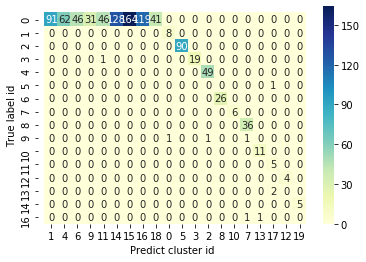

In [19]:
df = reorder(df)
sns_plot = sns.heatmap(df, cmap="YlGnBu", annot=True, fmt="d")
sns_plot.set_xlim(-0.5, len(df.columns))
sns_plot.set_ylim(len(df), -0.5)
sns_plot.set_xlabel('Predict cluster id')
sns_plot.set_ylabel('True label id')
fig = sns_plot.get_figure()
fig.savefig("clustering_labels/atis_output_kmeans.png", dpi=200)

In [55]:
def calc_h_accuracy(df):
    df_norm = df.apply(lambda x: x/x.sum(), axis=0)
    df_entropy = df_norm.apply(lambda x: x*np.log2(x+0.0001))
    return -np.sum(df_entropy.sum(axis=0)) / len(df.columns)
def calc_h_purity(df):
    df_norm = df.apply(lambda x: x/x.sum(), axis=1)
    df_entropy = df_norm.apply(lambda x: x*np.log2(x+0.0001))
    return -np.sum(df_entropy.sum(axis=0)) / len(df)
print(calc_h_accuracy(df))
print(calc_h_purity(df))

0.7565193684552368
1.2346917176074372


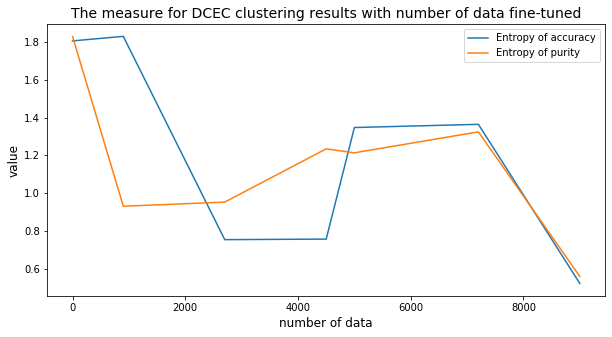

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = [0.521, 1.364, 1.347, 0.756, 0.753, 1.83, 1.806]
purity = [0.558, 1.324, 1.213, 1.234, 0.952, 0.93, 1.829]
data = [9000, 7200, 5000, 4500, 2700, 900, 0]

plt.figure(figsize=(10,5))
plt.plot(data, accuracy, label='Entropy of accuracy')
plt.plot(data, purity, label='Entropy of purity')
plt.legend(loc='best')
plt.title('The measure for DCEC clustering results with number of data fine-tuned', fontsize=14)
plt.xlabel('number of data', fontsize=12)
plt.ylabel('value', fontsize=12)
plt.savefig("clustering_labels/measure_se_dcec.png", dpi=200)
plt.show()
